# Reduced Order Models (ROM)

**Students:**

Guilherme Marim - RA: 232092

## Objective

Get a **Reduce Order Model** to solve the Kuramoto-Sivashinsk equation using a Neural Network (NN).

Kuramoto-Sivashinsk equation: 

\begin{equation}
    u_{t} + uu_{x} + \alpha u_{xx} + \gamma u_{xxxx} = 0
\end{equation}

The dataset that will be used to solve this equation by the NN was obtained using the finite diference method and the initial condition was extracted of the bellow function:

\begin{equation}
    u(x,t=0) = cos(\frac{\pi x}{20})(1 - sin(\frac{\pi x}{20}))
\end{equation}

## Loading Dataset

**Loading Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Loading DataSet Kuramoto-Sivashinsky**

In [ ]:
X = np.load('/content/drive/MyDrive/datasets/Kuramoto_X.npy')
T = np.load('/content/drive/MyDrive/datasets/Kuramoto_T.npy')
U = np.load('/content/drive/MyDrive/datasets/Kuramoto_U.npy')

In [ ]:
U.shape

(40001, 256)

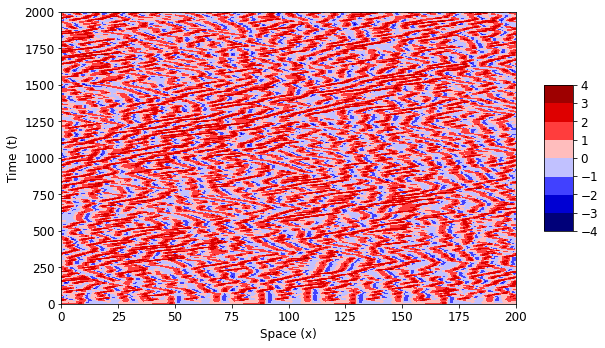

In [ ]:
def plot_data(X, T, U, title=''):
    fig, ax = plt.subplots(figsize=(9, 5))

    surf = ax.contourf(X, T, U, cmap=plt.get_cmap("seismic"))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    plt.xlabel('Space (x)')
    plt.ylabel('Time (t)')
    plt.tight_layout()

plot_data(X, T, U)

In [ ]:
def plot_data_compare(X, T, U, U_reduced, k, variance, title_1='Original data', title_2='Reduced data', title_3='Absolute difference'):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(15, 7))
    plt.suptitle(f'Training set reconstruction with {k} components ({round(variance, 2)}% variance)', y=1.02)

    surf1 = ax[0].contourf(X, T, U, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf1, ax=ax[0], ticks=None)
    ax[0].set_title(title_1)
    ax[0].set_ylabel('Time')

    surf2 = ax[1].contourf(X, T, U_reduced, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf2, ax=ax[1])
    ax[1].set_title(title_2)

    surf3 = ax[2].contourf(X, T, abs(U - U_reduced), cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf3, ax=ax[2])
    ax[2].set_title(title_3)

    plt.tight_layout()

    print(f'Mean error {round(abs(U - U_reduced).mean(), 2)}')

In [ ]:
def plot_time_serie(u_original, u_reconstruct, time=0):
    plt.figure(figsize=(18, 4))
    plt.title("Time serie")
    plt.subplot(1, 3, 1)
    plt.plot(u_original[time,:])
    plt.title('Original data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')

    plt.subplot(1, 3, 2)
    plt.plot(u_reconstruct[time,:])
    plt.title('Predicted data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')

    plt.subplot(1, 3, 3)
    plt.plot(u_original[time,:])
    plt.plot(u_reconstruct[time,:])
    plt.title('Both data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.show()

**Taking out the first 200 seconds**

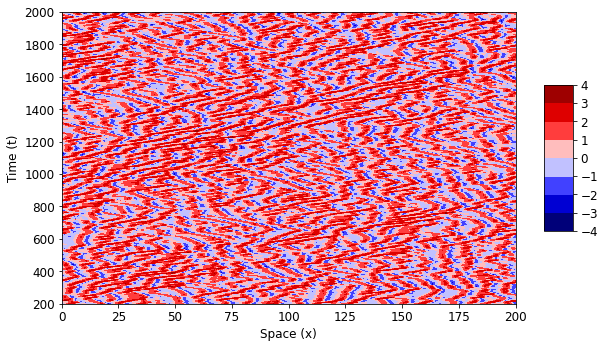

In [ ]:
# Taking out the first 200 seconds
U = U[4000:,:]
X = X[4000:,:]
T = T[4000:,:]

plot_data(X, T, U)

In [ ]:
U.shape

(36001, 256)

## Preprocessing

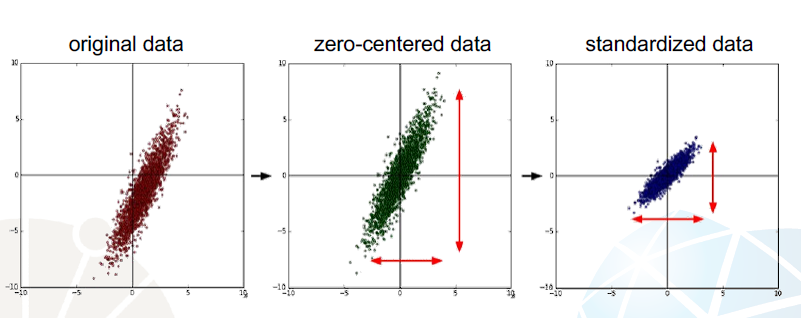

### Standardization

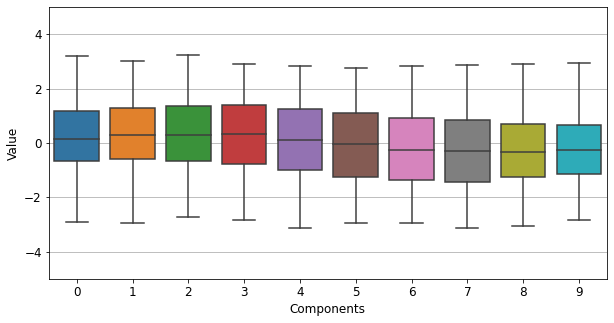

In [ ]:
#Data analysis with barplot
def barplot(X,plot='none', figsize=(10,5)):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.rcParams['axes.axisbelow'] = True
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=figsize)
    if (plot!='auto'):
        plt.ylim(-5,5)
    plt.xlabel('Components')
    plt.ylabel('Value')
    plt.grid(True, zorder=1)
    Xdf = pd.DataFrame(X)
    bp = sns.boxplot(data=Xdf)

barplot(U[:,100:110])

__Centralization.__ Data will be shifted to have $\mu$=0, where $\mu$ is the mean.

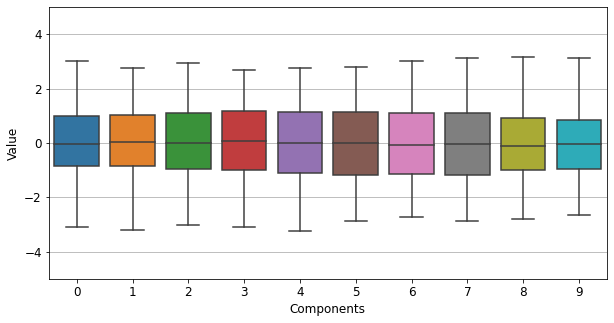

In [ ]:
# Centering data
def centralize(X):
    dims = X.shape[1]
    X_m = X.copy()
    for i in range(0, dims):
        mean = X[:,i].mean()       
        for j in range(0, len(X)):
            X_m[j][i] = X[j][i] - mean
    return X_m

Uc = centralize(U)
barplot(Uc[:,100:110])

__Standardization.__ `StandardScaler` will standardize features by removing the mean and scaling to unit variance.

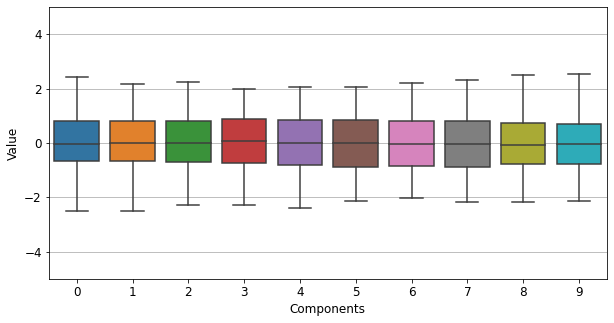

In [ ]:
# Standardize data
def standardize(X):    
    Xs = StandardScaler().fit_transform(X)
    return Xs

Us = standardize(U)
barplot(Us[:,100:110])

__Normalization.__ Data will be scaled between 0 and 1

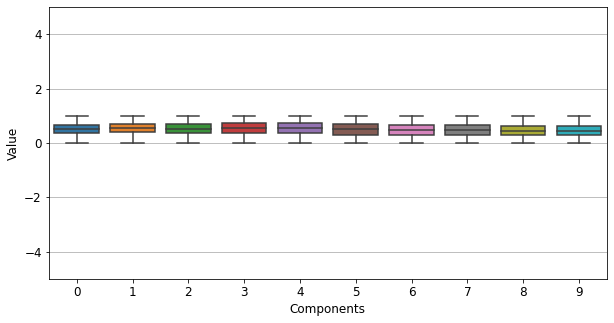

In [ ]:
# Normalize data
def normalize(X):    
    Xn = MinMaxScaler().fit_transform(X)
    return Xn

Un = normalize(U)
barplot(Un[:,100:110])

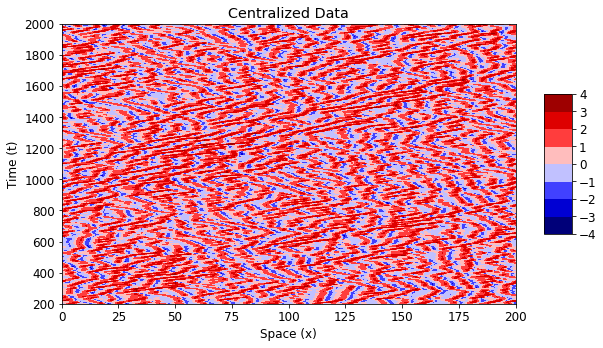

In [ ]:
Uc = centralize(U)
plot_data(X, T, Uc, title='Centralized Data')

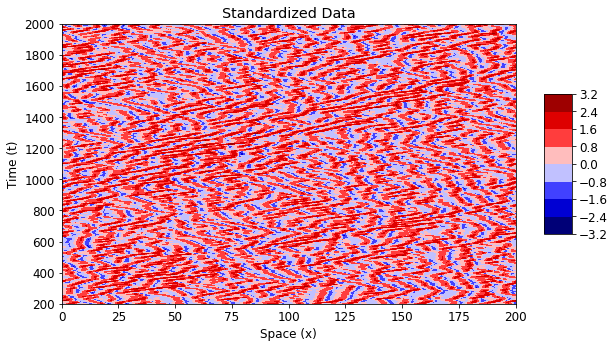

In [ ]:
Us = standardize(U)
plot_data(X, T, Us, title='Standardized Data')

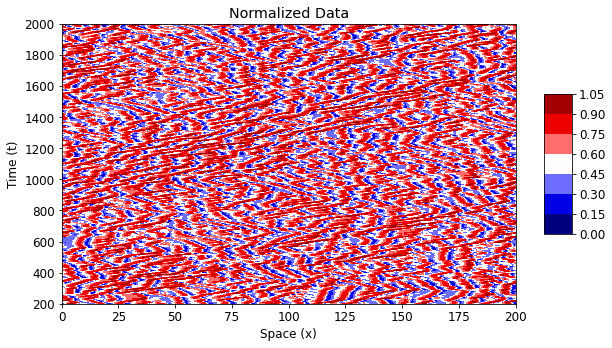

In [ ]:
Un = normalize(U)
plot_data(X, T, Un, title='Normalized Data')

## Principal Component Analysist (PCA) using ED

In this section we will proceed the Principal Component Analysis (PCA) using __Eigen-Decomposition__ (ED).

### Covariance Matrix

**Covariance** is a statistical measure of the joint variability of two random variables

**Population covariance:**

\begin{equation}
cov = \frac{\sum_{n}^{i=1}\left ( x_i - \mu \right )\cdot \left ( y_i - \nu \right )}{N}
\end{equation}

- $\mu$: mean of the X population, $\nu$: mean of the Y population
- N: number of examples in one set ($N_X = N_Y$)

**Sample covariance:**

\begin{equation}
cov = \frac{\sum_{n}^{i=1}\left ( x_i - \bar{x}\right )\cdot \left ( y_i - \bar{y} \right )}{n-1}
\end{equation}

- $x$: mean of the X sample set, $y$: mean of the Y sample set
- 
n: number of observations in one sample set ($n_X = n_Y$)


__Covariance Matrix.__ 

*Covariance Matrix* example:

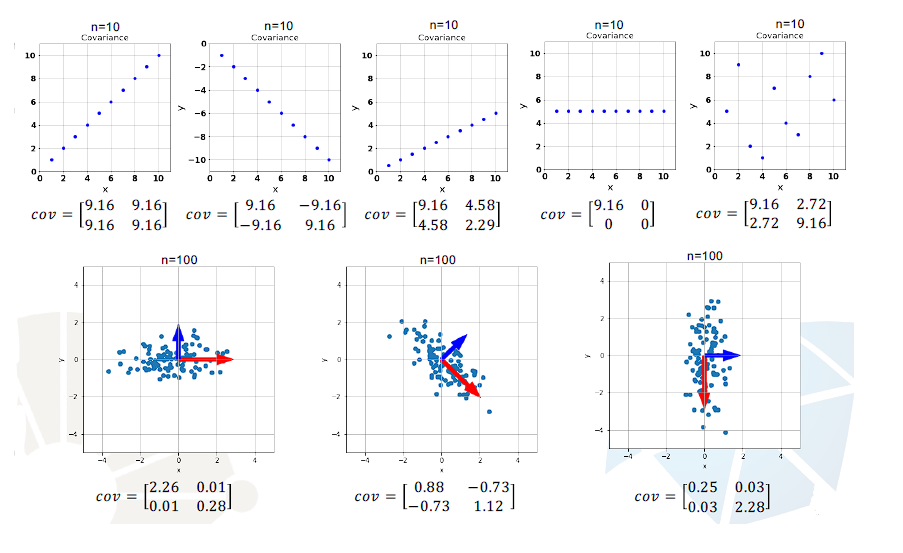


The `numpy` library provides a covariance matrix function `cov`:

In [ ]:
# Compute covariance matrix
def covmatrix(X):
    CM = np.cov(X.T)  
    return CM

CM = covmatrix(U)

### Eigenvalues and Eigenvectors

For a given matrix A, an eigenpair ($\vec{e}$,$\lambda$) satisfy:


\begin{equation}
A\cdot \vec{e} = \lambda\cdot \vec{e}
\end{equation}

**Eigenvectors: $\vec{e}$**

- A $𝑛 \times 𝑛$ matrix that is diagonizable have $n$ eigenvectors

**Eigenvalues: $\lambda$**

- $\lambda$ represents the magnitude of the spread in a direction


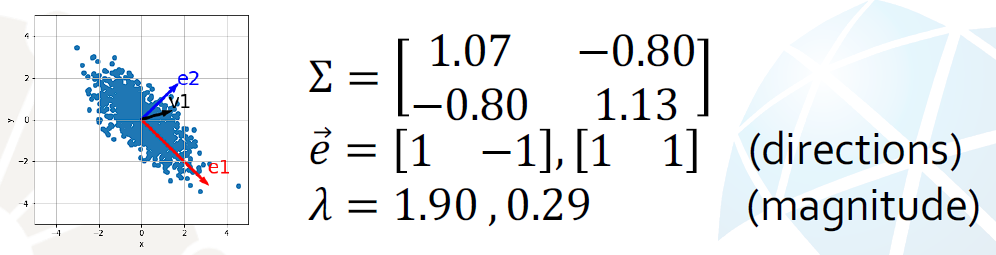

__Calculating Eigenvalues and Eigenvectors.__ The `numpy` library provides a _linear algebra_ package, that returns the Eigenvectors and Eigenvalues (not necessarily ordered).

e = [ $\lambda_1$, $\lambda_2$, $\lambda_3$ ... ]

E = [ [ $e1_1$, $e1_2$, $e1_3$, ... ]


In [ ]:
#Compute Eigenvectors and Eigenvalues
def eigen(CM):    
    evalues, evectors = np.linalg.eig(CM)
    return evalues, evectors
e, E = eigen(CM)

### Components Selection

The **percentage of the total variance** of the data in a principal component *$𝑃𝐶_i$* can be expressed by:

\begin{equation}
PC_i = \frac{\lambda_i}{\sum_{p}^{i=1}\lambda_i}\times 100%
\end{equation}

__Components Analysis.__ Checking the percentage of _variance explained_ by each eigenvalue.

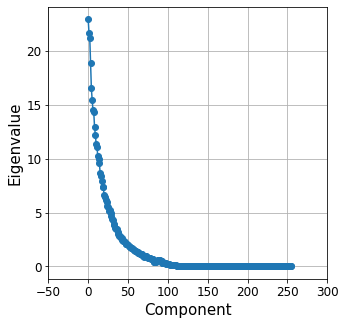

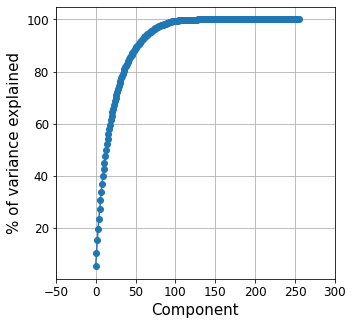

In [ ]:
# Components analysis
def component_analysis(e, plot='none'):
    varexp = 100* e/e.sum()
    cumvarexp = np.cumsum(varexp)

    # Plotting Eigenvalues...
    if (plot=='eigen'):
        plt.figure(figsize = (5,5))
        plt.plot(e, '-o')
        plt.grid(True)
        plt.xlabel('Component', fontsize = 15)
        plt.ylabel('Eigenvalue', fontsize = 15)
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)

    # Plotting Variance explained...
    if (plot=='varexp'):
        plt.figure(figsize = (5,5))
        plt.plot(cumvarexp, '-o')
        plt.xlabel('Component', fontsize = 15)
        plt.ylabel('% of variance explained', fontsize = 15)
        plt.grid(True)
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)

    plt.show()

#Viewing.... plot=['eigen', 'varexp']
component_analysis(e, plot='eigen')  
component_analysis(e, plot='varexp')

__Selecting Eigenvectors.__ Let's show the eigenvectors corresponding to the best _k_ eigenvalues:

In [ ]:
# Get the k most relevant eigenvalues
def components_select(e, E, k):
    best_index = (-e).argsort()[:k]
    pc = E[:, best_index]
    return pc

### Transforming data

__Transforming data to the new space.__ Now we need to transform the data to the new space with the selected components. At this moment we will transform the original data (U).

In [ ]:
# Calculating the eigenmatrix
def transform(X, PC):    
    return np.dot(X, PC)

In [ ]:
def inverse_transform(Xpc, PC):
    return np.dot(Xpc, PC.T)

In [ ]:
def explained_variance_ratio(e, k):
    varexp = e/e.sum()
    cumvarexp = np.cumsum(varexp)    
    total_modal_energy = cumvarexp[k-1]        
    return total_modal_energy*100

### POD Projection

Function responsible for makes the projection of the **POD** with the **reduced space** that preserves the **greatest energy of the system**

In [ ]:
def project(X, k):
    CM = covmatrix(X)
    e, E = eigen(CM)
    PC = components_select(e, E, k)
    total_modal_energy = explained_variance_ratio(e, k)
    print(f'total_modal_energy: {round(total_modal_energy, 2)}%')
    return transform(X, PC), PC, total_modal_energy

### Reconstructs the original space

Function that reconstructs the original space with the modes extracted in the POD projection through the product between the **projected U** and the **modes**

In [ ]:
def reconstruct(X_projected, modes):
    return inverse_transform(X_projected, modes)

### Function to calculate the relative error

The relative error is calculate through of the $l^2-norm$ applied to the **original data U** and **reconstructed data U**

The $l^2-norm$ $\mathbf{x}$ is a **vector norm** defined for a **complex vector**

\begin{equation}
    \mathbf{x} = \begin{bmatrix}
    x_{1}\\ 
    x_{2}\\ 
    \vdots\\ 
    x_{n}
    \end{bmatrix}
\end{equation}

by 

\begin{equation}
    \left | \mathbf{x} \right | = \sqrt{\sum_{k=1}^{n} \left | x_{k} \right |^{2}}
\end{equation}

The **relative error** is given by:

\begin{equation}
    \frac{l^2(\Phi _{ori}) - l^2(\Phi _{rec})}{l^2(\Phi _{ori})}
\end{equation}

where, 

$\Phi _{ori}$ = original data U
$\Phi _{rec}$ = reconstructed data U



In [ ]:
def POD_error(X_original, X_reconstructed):
    error = 100*np.linalg.norm(X_original - X_reconstructed, 2)
    error /= np.linalg.norm(X_original, 2)    
    print(f'The projection error for POD is {round(error, 2)}%')

### Creating a PCA_ED function

**Eigen-Decomposition (ED)**

- Matrix **decomposition: factorization** of a matrix into a product of matrices
- For square ($𝑛 \times 𝑛$) matrices:

\begin{equation}
A = U\cdot \Lambda \cdot U^{T}
\end{equation}

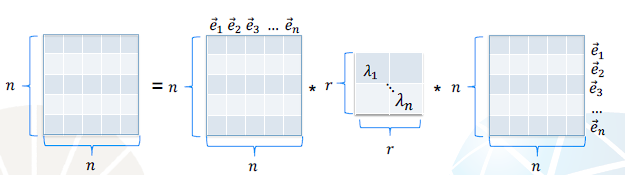

**Algorithm PCA flow using Eigen-Decomposition (ED):**

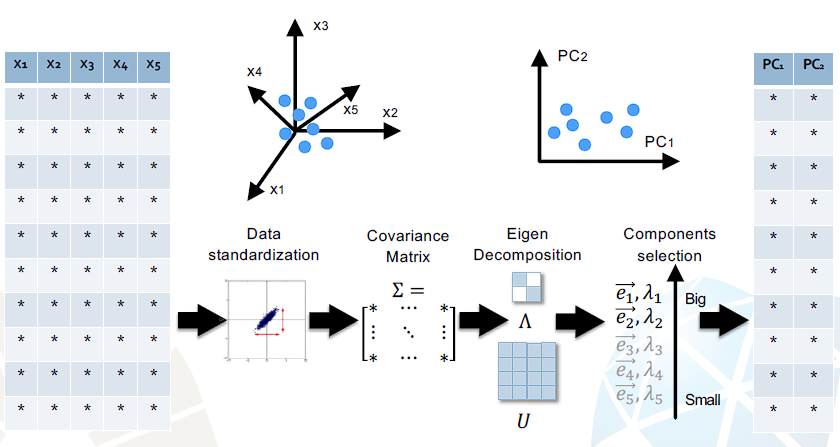



Creating our PCA function using Eigen-Decomposition (ED).

In [ ]:
# Creating a PCA function based on EVD
def PCA_ED(X, k):
    CM = covmatrix(X)
    e, E = eigen(CM)
    PC = components_select(e, E, k)
    Xpc = transform(X, PC)       
    Xpc_inv = inverse_transform(Xpc, PC)
    total_modal_energy = explained_variance_ratio(e, k)
    print(f"Modal energy preserved: {round(total_modal_energy, 2)}%")
    component_analysis(e, plot='varexp')
    return Xpc_inv, Xpc, PC, total_modal_energy

### Creating a PCA_SVD function

**Singular Value Decomposition (SVD):**

- Method for Matrix decomposition

\begin{equation}
A = U\cdot S \cdot V^{T}
\end{equation}

where,

$A$: Covariance Matrix

$U$: Left Singular vectors

$S$: Singular values

$V^{T}$: Right singular vectors

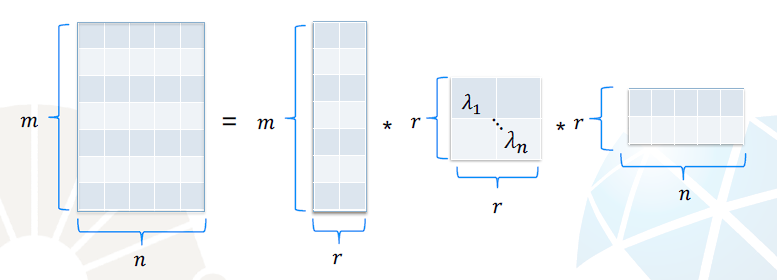

**Algorithm PCA flow using Singular Value Decomposition (SVD):**

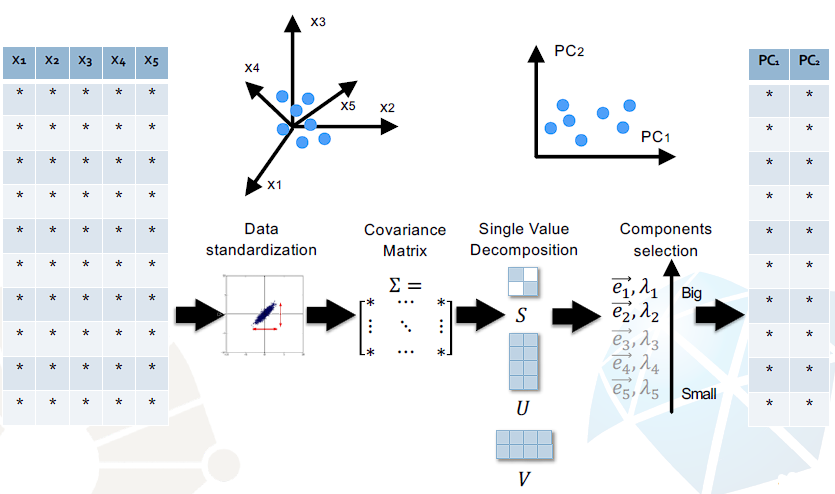


**Creating our PCA function using Singular Value Decomposition (SVD) with Numpy Library.**


In [ ]:
# Creating a PCA function using the SVD
def PCA_SVD(X, k):
    CM = covmatrix(X)
    [U, S, V] = svd(CM)
    PC = components_select(S, V, k)
    Xpc = transform(X, PC)
    Xpc_inv = inverse_transform(Xpc, PC)
    total_modal_energy = explained_variance_ratio(S, k)
    print(f"Modal energy preserved: {round(total_modal_energy, 2)}%")
    component_analysis(S, plot='varexp')
    return Xpc_inv, Xpc, PC, total_modal_energy

**Creating our PCA function using Singular Value Decomposition (SVD) with the SKlearn Library.**

In [ ]:
def PCA_SKL(X, k):    
    pca = PCA(n_components=k)
    Xpc = pca.fit_transform(X)
    Xpc_inv = pca.inverse_transform(Xpc)
    PC = pca.components_.T
    total_modal_energy = pca.explained_variance_ratio_.sum()
    print(f"Modal energy preserved: {round(total_modal_energy*100, 2)}%")
    pca_explain = PCA(n_components=256)
    pca_explain.fit_transform(X)
    component_analysis(pca_explain.explained_variance_, plot='varexp')
    return Xpc_inv, Xpc, PC, total_modal_energy

## Compare Results

### Results for PCA ED

**Original Data**

In [ ]:
k=100

Modal energy preserved: 99.36%


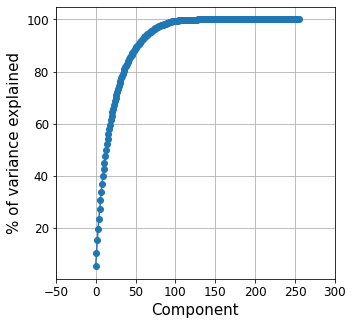

Mean error 0.08
The projection error for POD is 10.47%


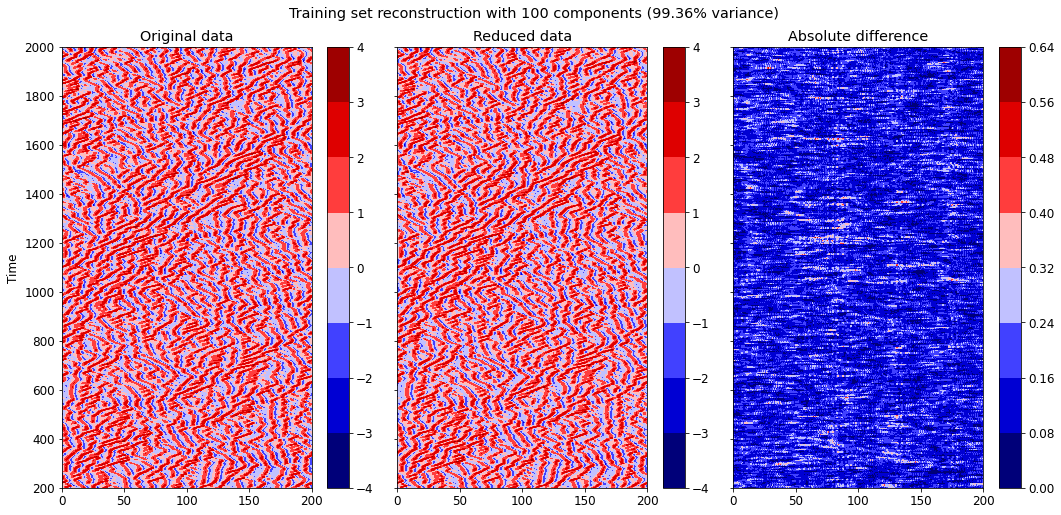

In [ ]:
# Original Data
U_original_reconstructed, U_original_projected, PC, variance = PCA_ED(U, k)
plot_data_compare(X, T, U, U_original_reconstructed, k, variance)
POD_error(U, U_original_reconstructed)

**Standardized Data**

Modal energy preserved: 99.36%


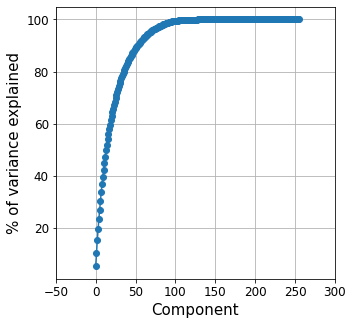

Mean error 0.06
The projection error for POD is 10.04%


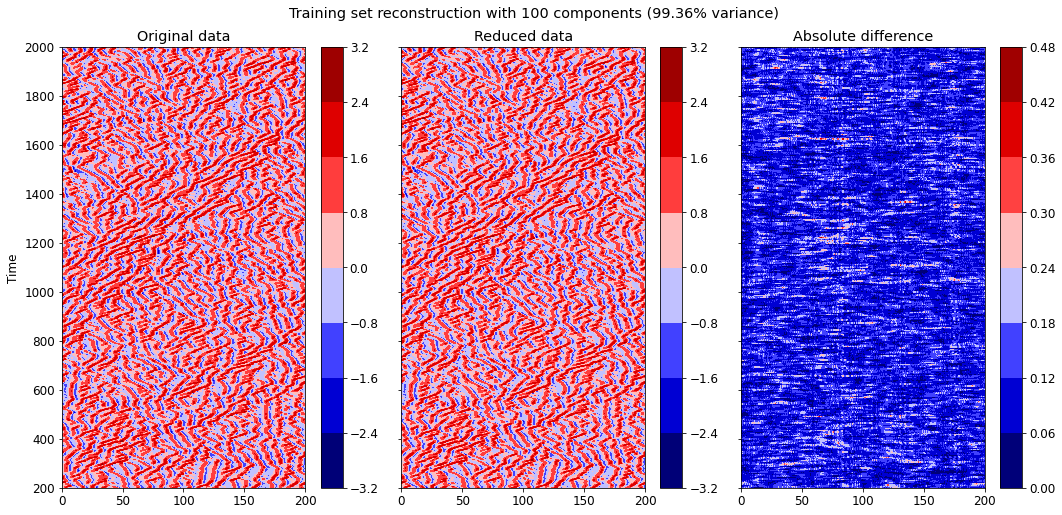

In [ ]:
# Standardized Data
U_standardized_reconstructed, U_standardized_projected, PC, variance = PCA_ED(standardize(U), k)
plot_data_compare(X, T, standardize(U), U_standardized_reconstructed, k, variance)
POD_error(standardize(U), U_standardized_reconstructed)

**Normalized Data**

Modal energy preserved: 99.37%


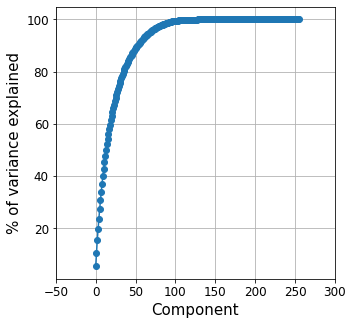

Mean error 0.02
The projection error for POD is 2.24%


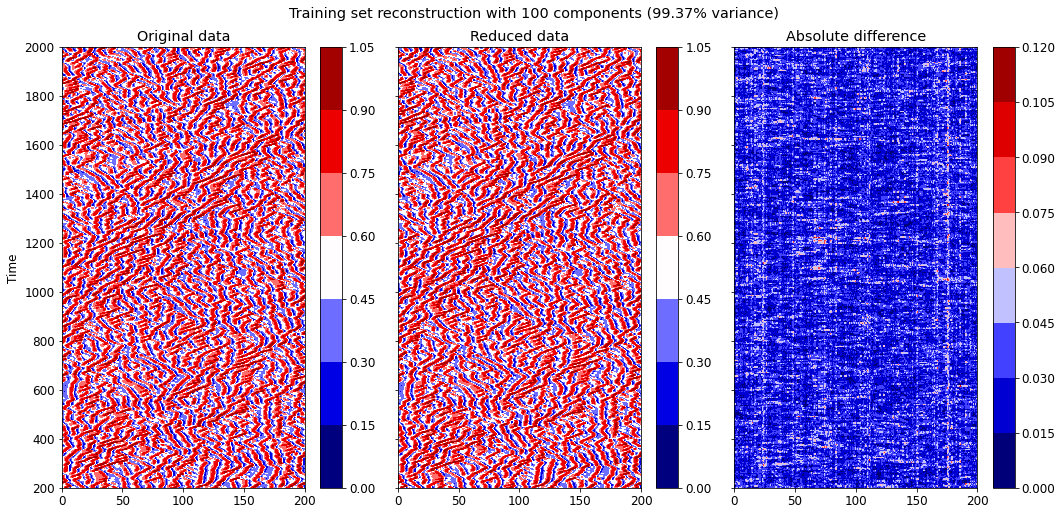

In [ ]:
# Normalized Data
U_normalized_reconstructed, U_normalized_projected, PC, variance = PCA_ED(normalize(U), k)
plot_data_compare(X, T, normalize(U), normalize(U_normalized_reconstructed), k, variance)
POD_error(normalize(U), normalize(U_normalized_reconstructed))

## Trainning the Neural Network

### Obtaining the projected U and the modes

In this work, the 100 principal components ($PC_i$ or modes) will be used, which preserve approximately 99.3% of the system variance.

Another important information is that the **original data U** has been **normalized**, being in the **range between 0 and 1**.

In [ ]:
k = 100
u_projected, modes, variance = project(normalize(U), k)
print(u_projected.shape)

total_modal_energy: 99.37%
(36001, 100)


### Strategy to trainning de neural network

The strategy that is being used for training the neural network is:

- Apply the **POD projection** in the original dataset, and thus obtain the $U$ function with the **reduced space** that **preserves the greatest energy** in the system.

- Once this is done, the neural network input data will be composed by samples $U_{i,j}$ (a current timestep) and the targets by samples between $U_{i,j}$ and $U_{i+k,j}$ (output of the NN), where this $U$ is the POD projection and **$k$** the amount of timeseries samples to be predicted.

Example:

For $k = 5$

input = $[U_{i,j}]$

output = $[U_{i+1,j}, U_{i+2,j}, U_{i+3,j}, U_{i+4,j}, U_{i+5,j}]$




### Function to generate the input and output data

In [ ]:
def generate_train_test_data(qtd_times_series_forecast, train_fraction=0.9):

  inputs = []
  outputs = []
  for i in range(1, u_projected.shape[0], qtd_times_series_forecast):
    input = []
    
    up = u_projected[i-1,:] 

    # input = np.zeros(100 + (qtd_times_series_forecast * 2))
    input = np.zeros(100)
    input[0:100] = up
    # x = i
    # for w in range(0, qtd_times_series_forecast*2):
    #   a = 100
    #   if w == 0 or w%2 == 0:
    #     # print(f'par: {w + a}, {(w+1) + a}, {x}')
    #     input[w + a:(w+1) + a] = u_projected[x,0]
    #   else:
    #     # print(f'impar: {w + a}, {(w+1) + a}, {x}')
    #     input[w + a:(w+1) + a] = u_projected[x,-1]
    #     x=x+1

    inputs.append(np.array(input))
    
    output = np.zeros(100 * qtd_times_series_forecast)
    output[0:100] = u_projected[i]
    for j in range(1, qtd_times_series_forecast):
      output[int(str(j) + "00"):int(str(j+1) + "00")] = u_projected[i+j]
    outputs.append(np.array(output))

  inputs = np.array(inputs)
  outputs = np.array(outputs)

  # The fraction of data used for training the model.
  test_fraction = 1 - train_fraction

  n_samples = inputs.shape[0]
  train_samples = int(train_fraction * n_samples)
  test_samples = n_samples - train_samples

  input_data_train = inputs[:train_samples]
  input_data_test = inputs[train_samples:]

  output_data_train = outputs[:train_samples]
  output_data_test = outputs[train_samples:]

  return input_data_train, output_data_train, input_data_test, output_data_test

### Function to create the NN model

In [ ]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras import regularizers
from keras.optimizers import SGD, Adam, Nadam, Adadelta
from sklearn.model_selection import train_test_split
import time

In [ ]:
def create_model(architecture_nn, input_data_train, output_data_train):
  # Creating the NN
  model = Sequential()
  for i, n in enumerate(architecture_nn):
    if i == 0:    
      model.add(Dense(n, input_dim=input_data_train.shape[1], kernel_initializer='glorot_uniform', activation='relu'))
    else:
      model.add(Dense(n, kernel_initializer='glorot_uniform', activation='relu'))
    
  model.add(Dense(output_data_train.shape[1], kernel_initializer='glorot_uniform', activation='linear')) # Out

  # Defining the optimizer
  optimizer = Adam()

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
  return model

### Function to forecast the time series

Function responsible by forecast the time series and reconstruct the original space

In [ ]:
def forecast_time_serie(model, input_data_test):
  forecast = model.predict(input_data_test)
  forecast = forecast.reshape( ( int((forecast.shape[0]*forecast.shape[1]/100)), 100) )
  reconstructed = reconstruct(forecast, modes)

  return reconstructed

### Generating samples for training

**Separating training and test data**

90% of the data will be separated for training and the remaining 10% for model validation

Will be created 5 models to analyse the accuracy of each one of them to forecast 1000, 100, 10, 5 and 1 time series

In [ ]:
input_data_train_1000, output_data_train_1000, input_data_test_1000, output_data_test_1000 = generate_train_test_data(1000)
input_data_train_100, output_data_train_100, input_data_test_100, output_data_test_100 = generate_train_test_data(100)
input_data_train_50, output_data_train_50, input_data_test_50, output_data_test_50 = generate_train_test_data(50)
input_data_train_20, output_data_train_20, input_data_test_20, output_data_test_20 = generate_train_test_data(20)
input_data_train_10, output_data_train_10, input_data_test_10, output_data_test_10 = generate_train_test_data(10)
input_data_train_5, output_data_train_5, input_data_test_5, output_data_test_5 = generate_train_test_data(5)
input_data_train, output_data_train, input_data_test, output_data_test = generate_train_test_data(1)

### Creating the model to forecast 1000 time series

In [ ]:
architecture_nn = [300]
model_1000 = create_model(architecture_nn, input_data_train_1000, output_data_train_1000)
model_1000.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_15 (Dense)             (None, 100000)            30100000  
Total params: 30,130,300
Trainable params: 30,130,300
Non-trainable params: 0
_________________________________________________________________


**Fitting the model**

In [ ]:
history_1000 = model_1000.fit(input_data_train_1000, output_data_train_1000, epochs=500, batch_size=1000, validation_data=(input_data_test_1000, output_data_test_1000), verbose=1)

Epoch 1/500
1/1 [==============================] - 1s 902ms/step - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1238 - val_mean_squared_error: 0.1238
Epoch 2/500
1/1 [==============================] - 0s 53ms/step - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.1237 - val_mean_squared_error: 0.1237
Epoch 3/500
1/1 [==============================] - 0s 54ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1236 - val_mean_squared_error: 0.1236
Epoch 4/500
1/1 [==============================] - 0s 54ms/step - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1235 - val_mean_squared_error: 0.1235
Epoch 5/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 6/500
1/1 [==============================] - 0s 57ms/step - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 7/500
1/1 [======================

**Input with 4 times series**

In [ ]:
input_data_test_1000.shape

(4, 100)

**Output with 4000 reconstructed times series**

In [ ]:
u_reconstructed_1000 = forecast_time_serie(model_1000, input_data_test_1000)
u_reconstructed_1000.shape

(4000, 256)

**Plotting the original data U normalized and the predicted and reconstructed data U**

Mean error 0.26


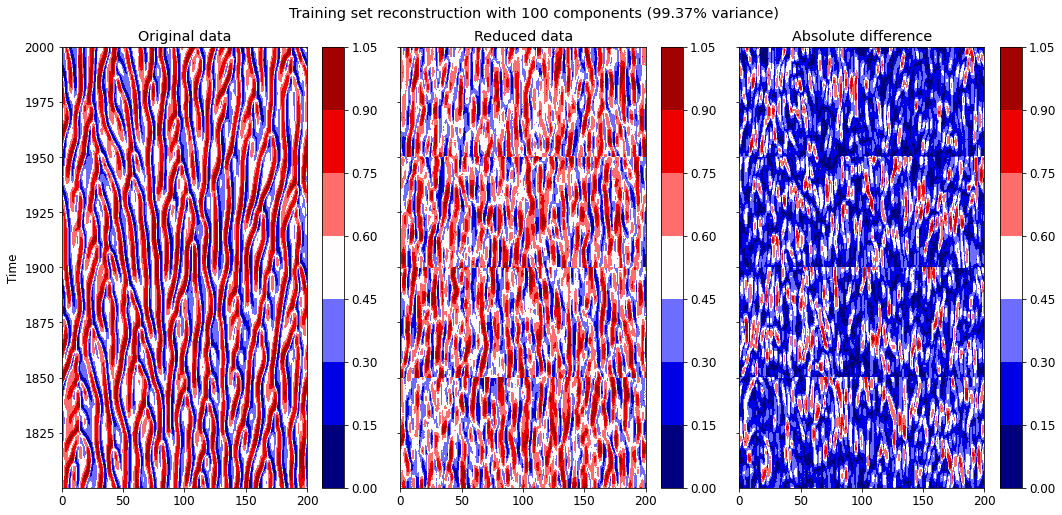

In [ ]:
plot_data_compare(X[32001:,:], T[32001:,:], normalize(U[32001:,:]), normalize(u_reconstructed_1000), k, variance)

**Plotting the original time series and the predicted time series**

Comparing the orginal time series for the validation data with the predicted time series

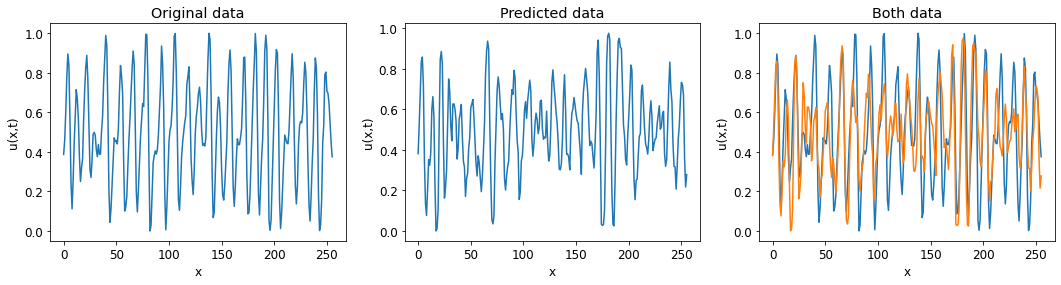

In [ ]:
plot_time_serie(normalize(U[32001:,:]), normalize(u_reconstructed_1000), time=10)

**The relative error between the original data U and the predicted and reconstructed data U**

In [ ]:
POD_error(normalize(U[32001:,:]), normalize(u_reconstructed_1000))

The projection error for POD is 21.14%


### Creating the model to forecast 100 time series

In [ ]:
architecture_nn = [300]
model_100 = create_model(architecture_nn, input_data_train_100, output_data_train_100)
model_100.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_17 (Dense)             (None, 10000)             3010000   
Total params: 3,040,300
Trainable params: 3,040,300
Non-trainable params: 0
_________________________________________________________________


**Fitting the model**

In [ ]:
history_100 = model_100.fit(input_data_train_100, output_data_train_100, epochs=500, batch_size=1000, validation_data=(input_data_test_100, output_data_test_100), verbose=1)

Epoch 1/500
1/1 [==============================] - 1s 880ms/step - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1240 - val_mean_squared_error: 0.1240
Epoch 2/500
1/1 [==============================] - 0s 46ms/step - loss: 0.1240 - mean_squared_error: 0.1240 - val_loss: 0.1231 - val_mean_squared_error: 0.1231
Epoch 3/500
1/1 [==============================] - 0s 41ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1222 - val_mean_squared_error: 0.1222
Epoch 4/500
1/1 [==============================] - 0s 41ms/step - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1214 - val_mean_squared_error: 0.1214
Epoch 5/500
1/1 [==============================] - 0s 40ms/step - loss: 0.1198 - mean_squared_error: 0.1198 - val_loss: 0.1207 - val_mean_squared_error: 0.1207
Epoch 6/500
1/1 [==============================] - 0s 42ms/step - loss: 0.1186 - mean_squared_error: 0.1186 - val_loss: 0.1201 - val_mean_squared_error: 0.1201
Epoch 7/500
1/1 [======================

**Input with 36 times series**

In [ ]:
input_data_test_100.shape

(36, 100)

**Output with 3600 reconstructed times series**

In [ ]:
u_reconstructed_100 = forecast_time_serie(model_100, input_data_test_100)
u_reconstructed_100.shape

(3600, 256)

**Plotting the original data U normalized and the predicted and reconstructed data U**

Mean error 0.17


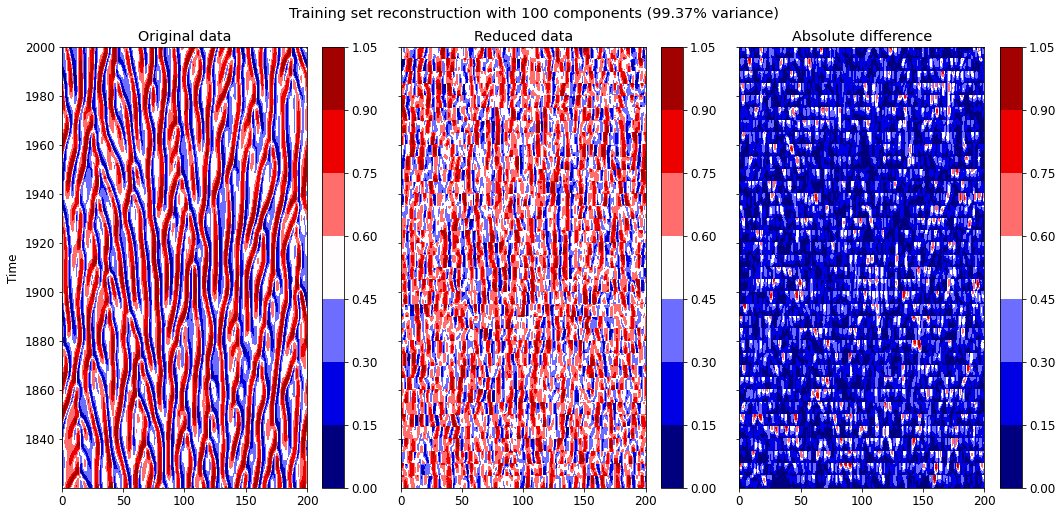

In [ ]:
plot_data_compare(X[32401:,:], T[32401:,:], normalize(U[32401:,:]), normalize(u_reconstructed_100), k, variance)

**Plotting the original time series and the predicted time series**

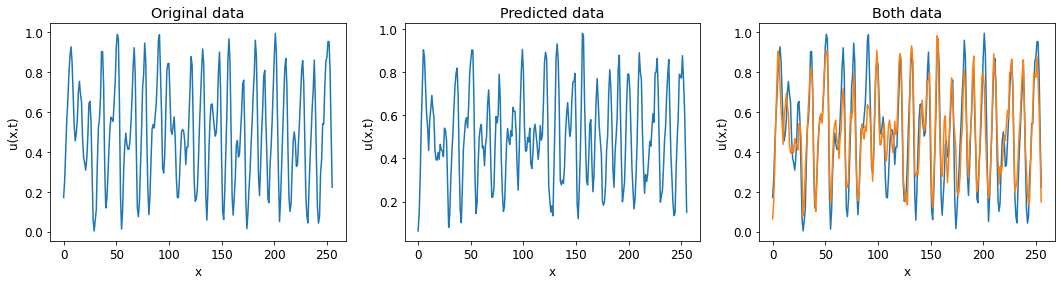

In [ ]:
plot_time_serie(normalize(U[32401:,:]), normalize(u_reconstructed_100), time=10)

**The relative error between the original data U and the predicted and reconstructed data U**

In [ ]:
POD_error(normalize(U[32401:,:]), normalize(u_reconstructed_100))

The projection error for POD is 15.62%


### Creating the model to forecast 50 time series

In [ ]:
architecture_nn = [300]
model_50 = create_model(architecture_nn, input_data_train_50, output_data_train_50)
model_50.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_19 (Dense)             (None, 5000)              1505000   
Total params: 1,535,300
Trainable params: 1,535,300
Non-trainable params: 0
_________________________________________________________________


**Fitting the model**

In [ ]:
history_50 = model_50.fit(input_data_train_50, output_data_train_50, epochs=500, batch_size=1000, validation_data=(input_data_test_50, output_data_test_50), verbose=1)

Epoch 1/500
1/1 [==============================] - 1s 902ms/step - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1252 - val_mean_squared_error: 0.1252
Epoch 2/500
1/1 [==============================] - 0s 46ms/step - loss: 0.1249 - mean_squared_error: 0.1249 - val_loss: 0.1237 - val_mean_squared_error: 0.1237
Epoch 3/500
1/1 [==============================] - 0s 40ms/step - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1224 - val_mean_squared_error: 0.1224
Epoch 4/500
1/1 [==============================] - 0s 42ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1213 - val_mean_squared_error: 0.1213
Epoch 5/500
1/1 [==============================] - 0s 42ms/step - loss: 0.1193 - mean_squared_error: 0.1193 - val_loss: 0.1203 - val_mean_squared_error: 0.1203
Epoch 6/500
1/1 [==============================] - 0s 41ms/step - loss: 0.1178 - mean_squared_error: 0.1178 - val_loss: 0.1193 - val_mean_squared_error: 0.1193
Epoch 7/500
1/1 [======================

**Input with 72 times series**

In [ ]:
input_data_test_50.shape

(72, 100)

**Output with 3600 reconstructed times series**

In [ ]:
u_reconstructed_50 = forecast_time_serie(model_50, input_data_test_50)
u_reconstructed_50.shape

(3600, 256)

**Plotting the original data U normalized and the predicted and reconstructed data U**

Mean error 0.12


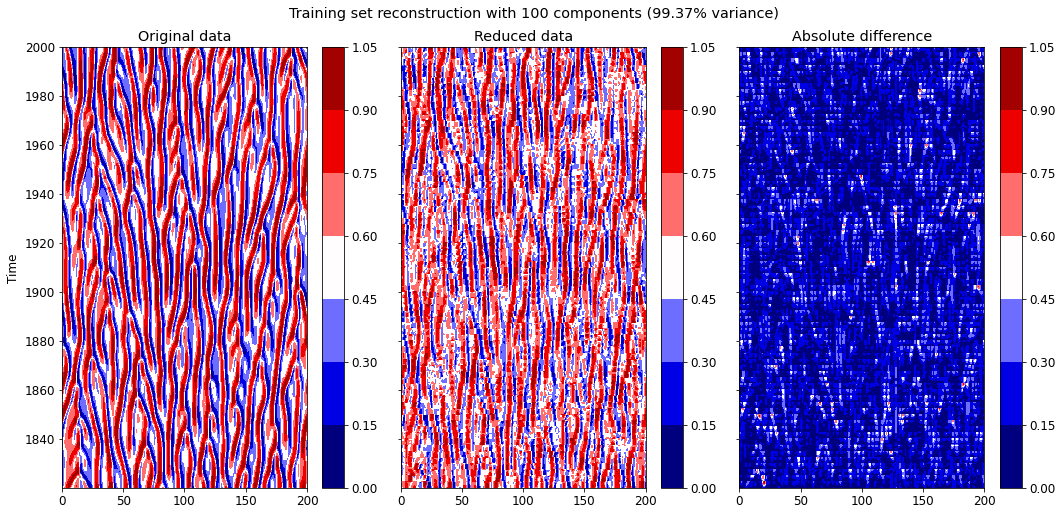

In [ ]:
plot_data_compare(X[32401:,:], T[32401:,:], normalize(U[32401:,:]), normalize(u_reconstructed_50), k, variance)

**Plotting the original time series and the predicted time series**

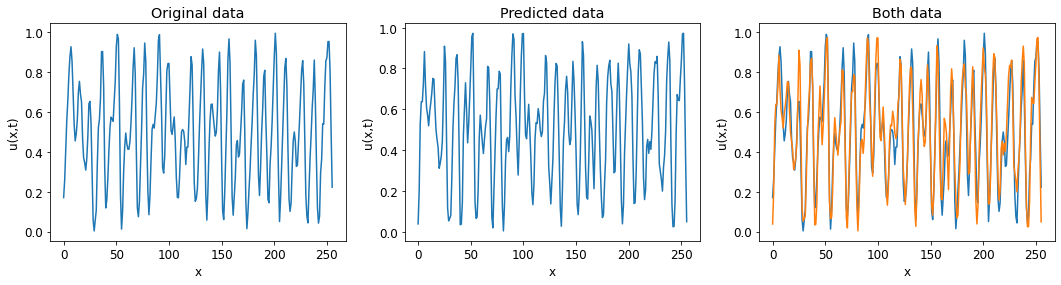

In [ ]:
plot_time_serie(normalize(U[32401:,:]), normalize(u_reconstructed_50), time=10)

**The relative error between the original data U and the predicted and reconstructed data U**

In [ ]:
POD_error(normalize(U[32401:,:]), normalize(u_reconstructed_50))

The projection error for POD is 12.13%


### Creating the model to forecast 20 time series

In [ ]:
architecture_nn = [300]
model_20 = create_model(architecture_nn, input_data_train_20, output_data_train_20)
model_20.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_21 (Dense)             (None, 2000)              602000    
Total params: 632,300
Trainable params: 632,300
Non-trainable params: 0
_________________________________________________________________


**Fitting the model**

In [ ]:
history_20 = model_20.fit(input_data_train_20, output_data_train_20, epochs=500, batch_size=1000, validation_data=(input_data_test_20, output_data_test_20), verbose=1)

Epoch 1/500
2/2 [==============================] - 1s 519ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1256 - val_mean_squared_error: 0.1256
Epoch 2/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1245 - mean_squared_error: 0.1245 - val_loss: 0.1225 - val_mean_squared_error: 0.1225
Epoch 3/500
2/2 [==============================] - 0s 31ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1202 - val_mean_squared_error: 0.1202
Epoch 4/500
2/2 [==============================] - 0s 31ms/step - loss: 0.1165 - mean_squared_error: 0.1165 - val_loss: 0.1180 - val_mean_squared_error: 0.1180
Epoch 5/500
2/2 [==============================] - 0s 33ms/step - loss: 0.1131 - mean_squared_error: 0.1131 - val_loss: 0.1156 - val_mean_squared_error: 0.1156
Epoch 6/500
2/2 [==============================] - 0s 31ms/step - loss: 0.1095 - mean_squared_error: 0.1095 - val_loss: 0.1132 - val_mean_squared_error: 0.1132
Epoch 7/500
2/2 [======================

**Input with 180 times series**

In [ ]:
input_data_test_20.shape

(180, 100)

**Output with 3600 reconstructed times series**

In [ ]:
u_reconstructed_20 = forecast_time_serie(model_20, input_data_test_20)
u_reconstructed_20.shape

(3600, 256)

**Plotting the original data U normalized and the predicted and reconstructed data U**

Mean error 0.08


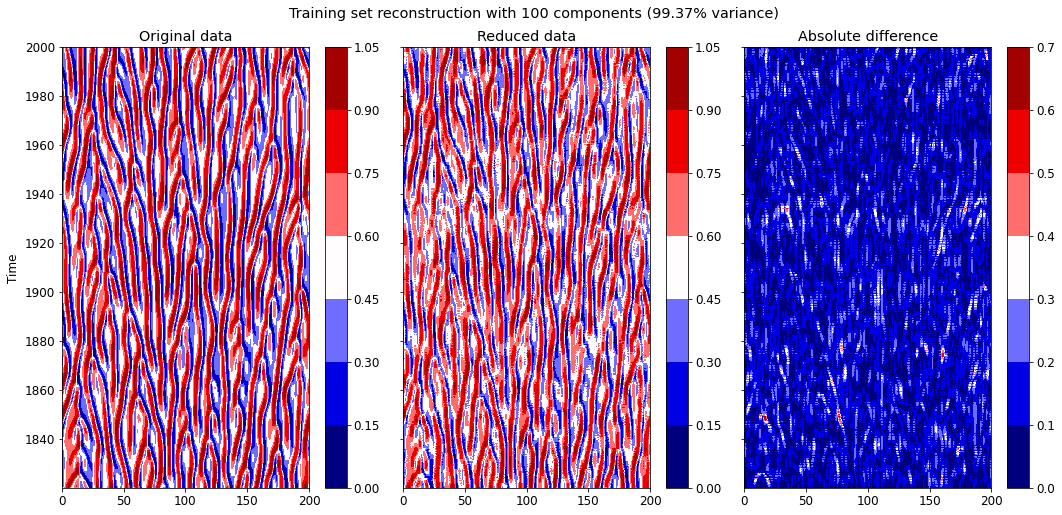

In [ ]:
plot_data_compare(X[32401:,:], T[32401:,:], normalize(U[32401:,:]), normalize(u_reconstructed_20), k, variance)

**Plotting the original time series and the predicted time series**

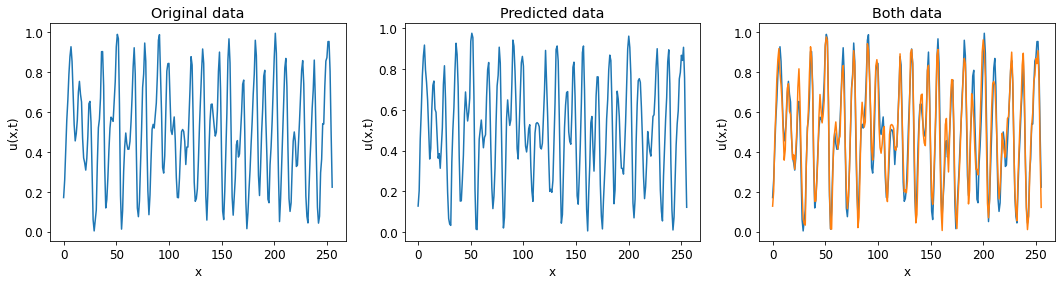

In [ ]:
plot_time_serie(normalize(U[32401:,:]), normalize(u_reconstructed_20), time=10)

**The relative error between the original data U and the predicted and reconstructed data U**

In [ ]:
POD_error(normalize(U[32401:,:]), normalize(u_reconstructed_20))

The projection error for POD is 9.06%


### Creating the model to forecast 10 time series

In [ ]:
architecture_nn = [300]
model_10 = create_model(architecture_nn, input_data_train_10, output_data_train_10)
model_10.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_23 (Dense)             (None, 1000)              301000    
Total params: 331,300
Trainable params: 331,300
Non-trainable params: 0
_________________________________________________________________


**Fitting the model**

In [ ]:
history_10 = model_10.fit(input_data_train_10, output_data_train_10, epochs=500, batch_size=1000, validation_data=(input_data_test_10, output_data_test_10), verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 86ms/step - loss: 0.1349 - mean_squared_error: 0.1349 - val_loss: 0.1257 - val_mean_squared_error: 0.1257
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 0.1226 - mean_squared_error: 0.1226 - val_loss: 0.1203 - val_mean_squared_error: 0.1203
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1146 - mean_squared_error: 0.1146 - val_loss: 0.1151 - val_mean_squared_error: 0.1151
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1072 - mean_squared_error: 0.1072 - val_loss: 0.1096 - val_mean_squared_error: 0.1096
Epoch 5/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0998 - mean_squared_error: 0.0998 - val_loss: 0.1040 - val_mean_squared_error: 0.1040
Epoch 6/500
4/4 [==============================] - 0s 14ms/step - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 7/500
4/4 [=======================

**Input with 360 times series**

In [ ]:
input_data_test_10.shape

(360, 100)

**Output with 3600 reconstructed times series**

In [ ]:
u_reconstructed_10 = forecast_time_serie(model_10, input_data_test_10)
u_reconstructed_10.shape

(3600, 256)

**Plotting the original data U normalized and the predicted and reconstructed data U**

Mean error 0.05


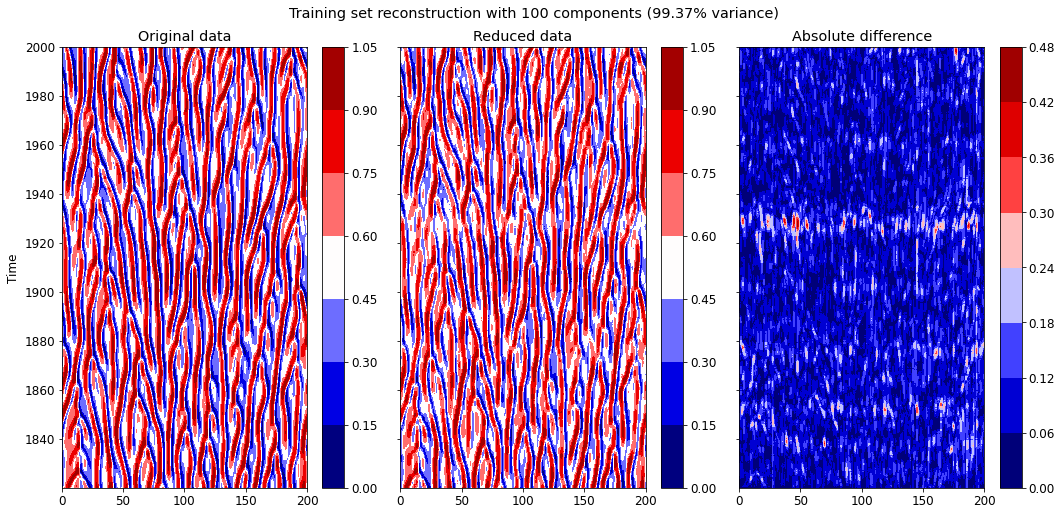

In [ ]:
plot_data_compare(X[32401:,:], T[32401:,:], normalize(U[32401:,:]), normalize(u_reconstructed_10), k, variance)

**Plotting the original time series and the predicted time series**

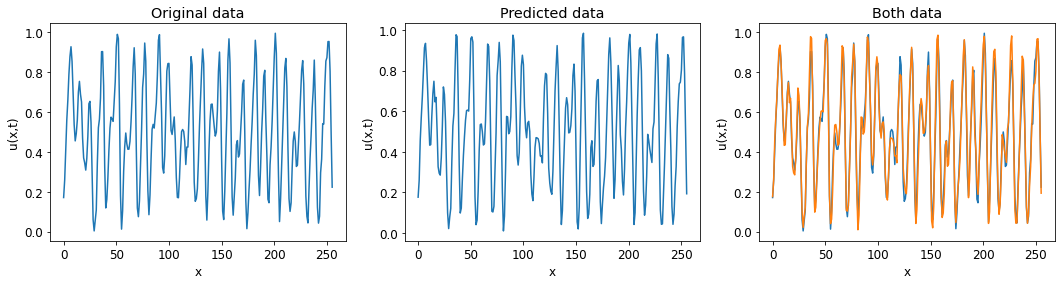

In [ ]:
plot_time_serie(normalize(U[32401:,:]), normalize(u_reconstructed_10), time=10)

**The relative error between the original data U and the predicted and reconstructed data U**

In [ ]:
POD_error(normalize(U[32401:,:]), normalize(u_reconstructed_10))

The projection error for POD is 6.72%


### Creating the model to forecast 5 time series

In [ ]:
architecture_nn = [300]
model_5 = create_model(architecture_nn, input_data_train_5, output_data_train_5)
model_5.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_25 (Dense)             (None, 500)               150500    
Total params: 180,800
Trainable params: 180,800
Non-trainable params: 0
_________________________________________________________________


**Fitting the model**

In [ ]:
history_5 = model_5.fit(input_data_train_5, output_data_train_5, epochs=500, batch_size=1000, validation_data=(input_data_test_5, output_data_test_5), verbose=1)

Epoch 1/500
7/7 [==============================] - 1s 52ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.1260 - val_mean_squared_error: 0.1260
Epoch 2/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1172 - mean_squared_error: 0.1172 - val_loss: 0.1151 - val_mean_squared_error: 0.1151
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.1045 - val_mean_squared_error: 0.1045
Epoch 4/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.0939 - val_mean_squared_error: 0.0939
Epoch 5/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0742 - mean_squared_error: 0.0742 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
Epoch 6/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - val_loss: 0.0715 - val_mean_squared_error: 0.0715
Epoch 7/500
7/7 [============================

**Input with 720 times series**

In [ ]:
input_data_test_5.shape

(720, 100)

**Output with 3600 reconstructed times series**

In [ ]:
u_reconstructed_5 = forecast_time_serie(model_5, input_data_test_5)
u_reconstructed_5.shape

(3600, 256)

**Plotting the original data U normalized and the predicted and reconstructed data U**

Mean error 0.04


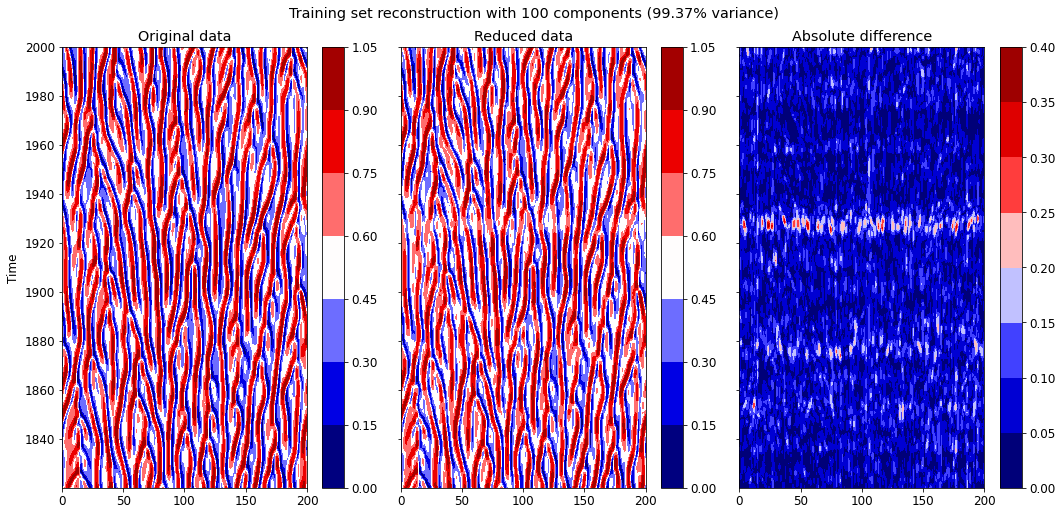

In [ ]:
plot_data_compare(X[32401:,:], T[32401:,:], normalize(U[32401:,:]), normalize(u_reconstructed_5), k, variance)

**Plotting the original time series and the predicted time series**

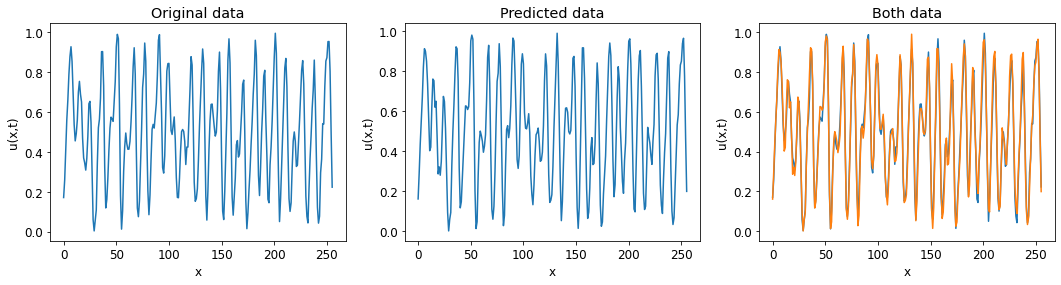

In [ ]:
plot_time_serie(normalize(U[32401:,:]), normalize(u_reconstructed_5), time=10)

**The relative error between the original data U and the predicted and reconstructed data U**

In [ ]:
POD_error(normalize(U[32401:,:]), normalize(u_reconstructed_5))

The projection error for POD is 5.14%


### Creating the model to forecast 1 time serie

In [ ]:
architecture_nn = [300]
model = create_model(architecture_nn, input_data_train, output_data_train)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               30100     
Total params: 60,400
Trainable params: 60,400
Non-trainable params: 0
_________________________________________________________________


**Fitting the model**

In [ ]:
history = model.fit(input_data_train, output_data_train, epochs=500, batch_size=1000, validation_data=(input_data_test, output_data_test), verbose=1)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.1266 - mean_squared_error: 0.1266 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 7/500
33/33 [==============

**Input with 3600 times series**

In [ ]:
input_data_test.shape

(3600, 100)

**Output with 3600 reconstructed times series**

In [ ]:
u_reconstructed = forecast_time_serie(model, input_data_test)
u_reconstructed.shape

(3600, 256)

**Plotting the original data U normalized and the predicted and reconstructed data U**

Mean error 0.04


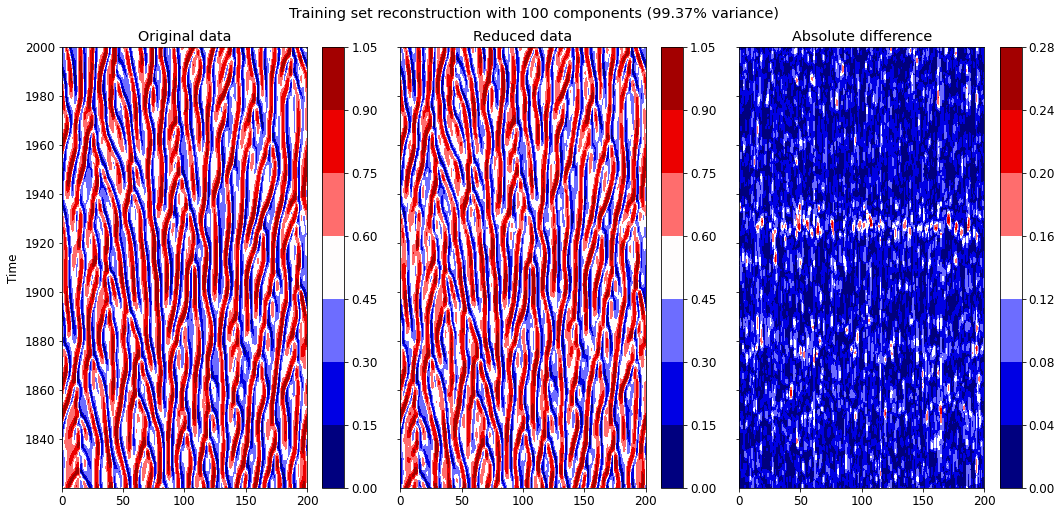

In [ ]:
plot_data_compare(X[32401:,:], T[32401:,:], normalize(U[32401:,:]), normalize(u_reconstructed), k, variance)

**Plotting the original time series and the predicted time series**

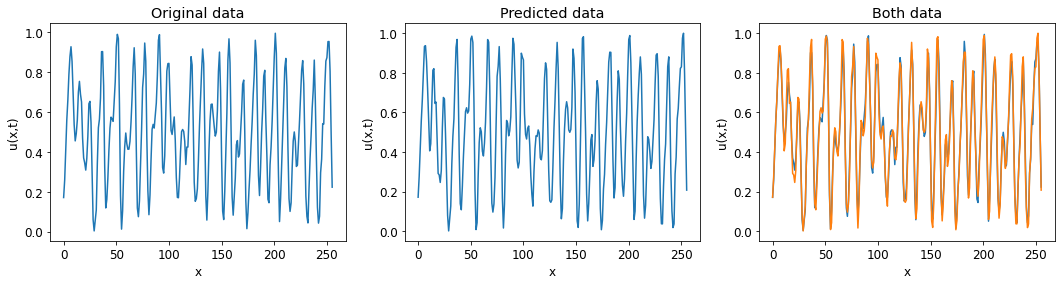

In [ ]:
plot_time_serie(normalize(U[32401:,:]), normalize(u_reconstructed), time=10)

**The relative error between the original data U and the predicted and reconstructed data U**

In [ ]:
POD_error(normalize(U[32401:,:]), normalize(u_reconstructed))

The projection error for POD is 5.56%
